# Spatial View Cell Analysis

Spatial view cells fire when the animal is *looking at* a specific location,
not when the animal is *at* that location. This notebook demonstrates:

1. Simulating spatial view cells
2. Computing view fields (binned by viewed location)
3. Comparing view fields to place fields
4. Classifying spatial view cells

**Key difference from place cells:**
- **Place cell**: fires when animal is AT a location
- **Spatial view cell**: fires when animal is LOOKING AT a location

## Learning Objectives

By the end of this notebook, you will be able to:

- Understand the difference between place cells and spatial view cells
- Simulate spatial view cells with known tuning properties
- Compute view fields indexed by viewed location
- Use metrics to classify cells as spatial view vs place cells
- Work with field of view constraints

**Estimated time**: 15-20 minutes

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from neurospatial import (
    Environment,
    FieldOfView,
    SpatialViewCellModel,
    compute_place_field,
    compute_spatial_view_field,
    compute_viewed_location,
    heading_from_velocity,
    spatial_view_cell_metrics,
)
from neurospatial.simulation import PlaceCellModel, generate_poisson_spikes

# Set random seed for reproducibility
rng = np.random.default_rng(42)

# Configure matplotlib
plt.rcParams["figure.figsize"] = (12, 10)
plt.rcParams["font.size"] = 11

## Part 1: Create Environment and Trajectory

First, we create a square arena and simulate animal movement with realistic heading.

In [2]:
# Create environment
samples = rng.uniform(0, 100, (2000, 2))
env = Environment.from_samples(samples, bin_size=5.0)
env.units = "cm"
print(f"Environment: {env.n_bins} bins")

Environment: 433 bins


In [3]:
# Generate trajectory with realistic heading
n_time = 10000
dt = 0.02  # 50 Hz
times = np.arange(n_time) * dt

# Smooth random walk
velocities = np.cumsum(rng.normal(0, 0.5, (n_time, 2)), axis=0)
velocities = np.clip(velocities, -20, 20)  # Limit speed
positions = 50 + np.cumsum(velocities * dt, axis=0)
positions = np.clip(positions, 10, 90)  # Stay in bounds

# Compute heading from velocity
headings = heading_from_velocity(positions, dt, min_speed=2.0, smoothing_sigma=3.0)

print(f"Trajectory: {n_time} samples, {times[-1]:.1f}s duration")
print(
    f"Position range: x=[{positions[:, 0].min():.1f}, {positions[:, 0].max():.1f}], "
    f"y=[{positions[:, 1].min():.1f}, {positions[:, 1].max():.1f}]"
)

Trajectory: 10000 samples, 200.0s duration
Position range: x=[10.0, 90.0], y=[10.0, 54.5]


## Part 2: Compute Viewed Locations

The key concept for spatial view cells is the **viewed location** - where the animal
is looking, not where it is. We compute this from position and heading.

Valid view samples: 10000 / 10000


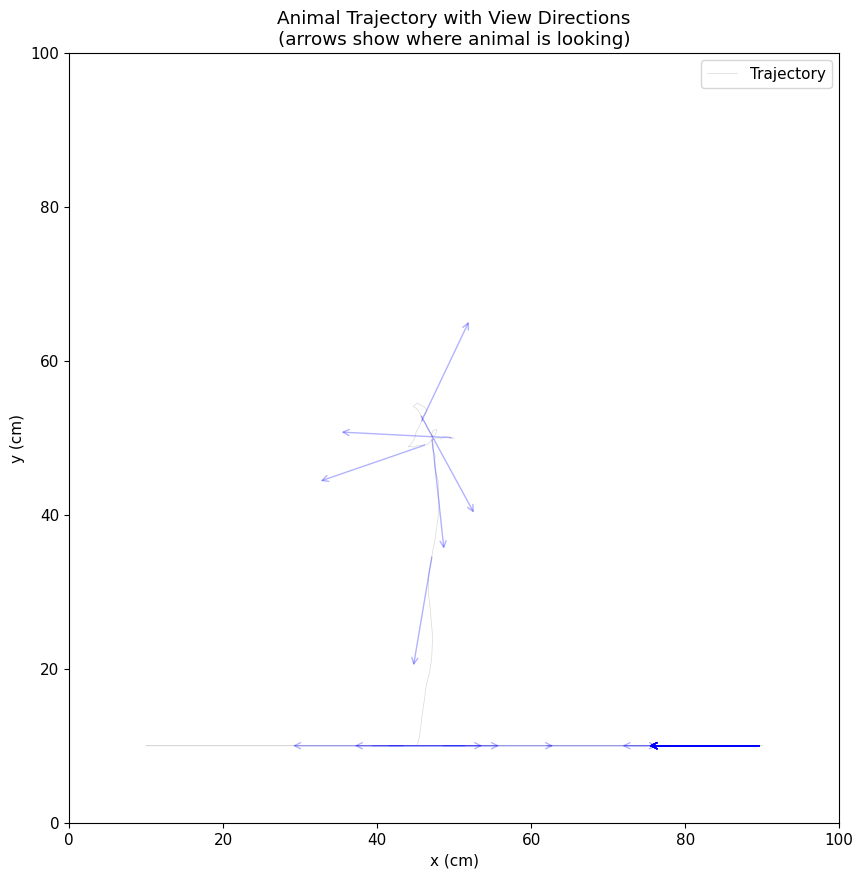

In [4]:
# Compute viewed locations
# This is where the animal is looking, not where it is
viewed_locations = compute_viewed_location(
    positions, headings, view_distance=15.0, method="fixed_distance"
)
valid_views = np.all(np.isfinite(viewed_locations), axis=1)
print(f"Valid view samples: {np.sum(valid_views)} / {n_time}")

# Visualize trajectory and view directions
fig, ax = plt.subplots(figsize=(10, 10))

# Sample every 100th point for visualization
sample_idx = np.arange(0, n_time, 100)

ax.plot(
    positions[:, 0],
    positions[:, 1],
    "gray",
    alpha=0.3,
    linewidth=0.5,
    label="Trajectory",
)

# Plot view directions as arrows
for i in sample_idx:
    if valid_views[i]:
        ax.annotate(
            "",
            xy=viewed_locations[i],
            xytext=positions[i],
            arrowprops={"arrowstyle": "->", "color": "blue", "alpha": 0.3},
        )

ax.set_xlabel("x (cm)")
ax.set_ylabel("y (cm)")
ax.set_title(
    "Animal Trajectory with View Directions\n(arrows show where animal is looking)"
)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_aspect("equal")
ax.legend()
plt.show()

## Part 3: Simulate a Spatial View Cell

A spatial view cell fires when the animal is **looking at** a specific location,
regardless of where the animal is physically located.

In [5]:
# Simulate a spatial view cell
# This cell fires when looking at (70, 50), regardless of position
preferred_view = np.array([70.0, 50.0])

svc_model = SpatialViewCellModel(
    env=env,
    preferred_view_location=preferred_view,
    view_field_width=12.0,
    view_distance=15.0,
    gaze_model="fixed_distance",
    max_rate=25.0,
    baseline_rate=0.5,
)

# Generate firing rates and spikes
svc_rates = svc_model.firing_rate(positions, times=times, headings=headings)
svc_spikes = generate_poisson_spikes(svc_rates, times, seed=42)

print(f"Spatial view cell: {len(svc_spikes)} spikes")
print(f"Mean firing rate: {len(svc_spikes) / times[-1]:.2f} Hz")
print(f"Preferred view location: {preferred_view}")

Spatial view cell: 127 spikes
Mean firing rate: 0.64 Hz
Preferred view location: [70. 50.]


## Part 4: Simulate a Place Cell for Comparison

For comparison, we simulate a place cell that fires when the animal is **at**
the same location (70, 50), not when looking at it.

In [6]:
# Simulate a place cell for comparison
# This cell fires when AT (70, 50), not when looking at it
place_model = PlaceCellModel(
    env=env,
    center=np.array([70.0, 50.0]),
    width=12.0,
    max_rate=25.0,
    baseline_rate=0.5,
)

pc_rates = place_model.firing_rate(positions)
pc_spikes = generate_poisson_spikes(pc_rates, times, seed=43)

print(f"Place cell: {len(pc_spikes)} spikes")
print(f"Mean firing rate: {len(pc_spikes) / times[-1]:.2f} Hz")

Place cell: 148 spikes
Mean firing rate: 0.74 Hz


## Part 5: Compute View Fields and Place Fields

Now we compute two types of fields for each cell:

1. **View field**: Firing rate indexed by **viewed location**
2. **Place field**: Firing rate indexed by **animal position**

For a spatial view cell, the view field should show clear tuning, while the
place field may appear diffuse. The opposite pattern holds for place cells.

In [7]:
# Compute view fields and place fields

# View field: binned by VIEWED location
svc_view_result = compute_spatial_view_field(
    env,
    svc_spikes,
    times,
    positions,
    headings,
    view_distance=15.0,
    smoothing_method="diffusion_kde",
    bandwidth=8.0,
)
svc_view_field = svc_view_result.field

# Place field: binned by POSITION
svc_place_field = compute_place_field(
    env, svc_spikes, times, positions, smoothing_method="diffusion_kde", bandwidth=8.0
)

print("Spatial view cell fields computed")
print(f"  View field peak: {np.nanmax(svc_view_field):.2f} Hz")
print(f"  Place field peak: {np.nanmax(svc_place_field):.2f} Hz")

/Users/edeno/Documents/GitHub/neurospatial/.venv/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/edeno/Documents/GitHub/neurospatial/.venv/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


Spatial view cell fields computed
  View field peak: 4.36 Hz
  Place field peak: 3.04 Hz


In [8]:
# Same for place cell
pc_view_result = compute_spatial_view_field(
    env,
    pc_spikes,
    times,
    positions,
    headings,
    view_distance=15.0,
    smoothing_method="diffusion_kde",
    bandwidth=8.0,
)
pc_view_field = pc_view_result.field

pc_place_field = compute_place_field(
    env, pc_spikes, times, positions, smoothing_method="diffusion_kde", bandwidth=8.0
)

print("Place cell fields computed")
print(f"  View field peak: {np.nanmax(pc_view_field):.2f} Hz")
print(f"  Place field peak: {np.nanmax(pc_place_field):.2f} Hz")

Place cell fields computed
  View field peak: 5.02 Hz
  Place field peak: 5.38 Hz


## Part 6: Visualize the Comparison

The key insight is:
- **Spatial view cell**: View field shows clear tuning at preferred location
- **Place cell**: Place field shows clear tuning at preferred location

The "wrong" field type for each cell should appear more diffuse.

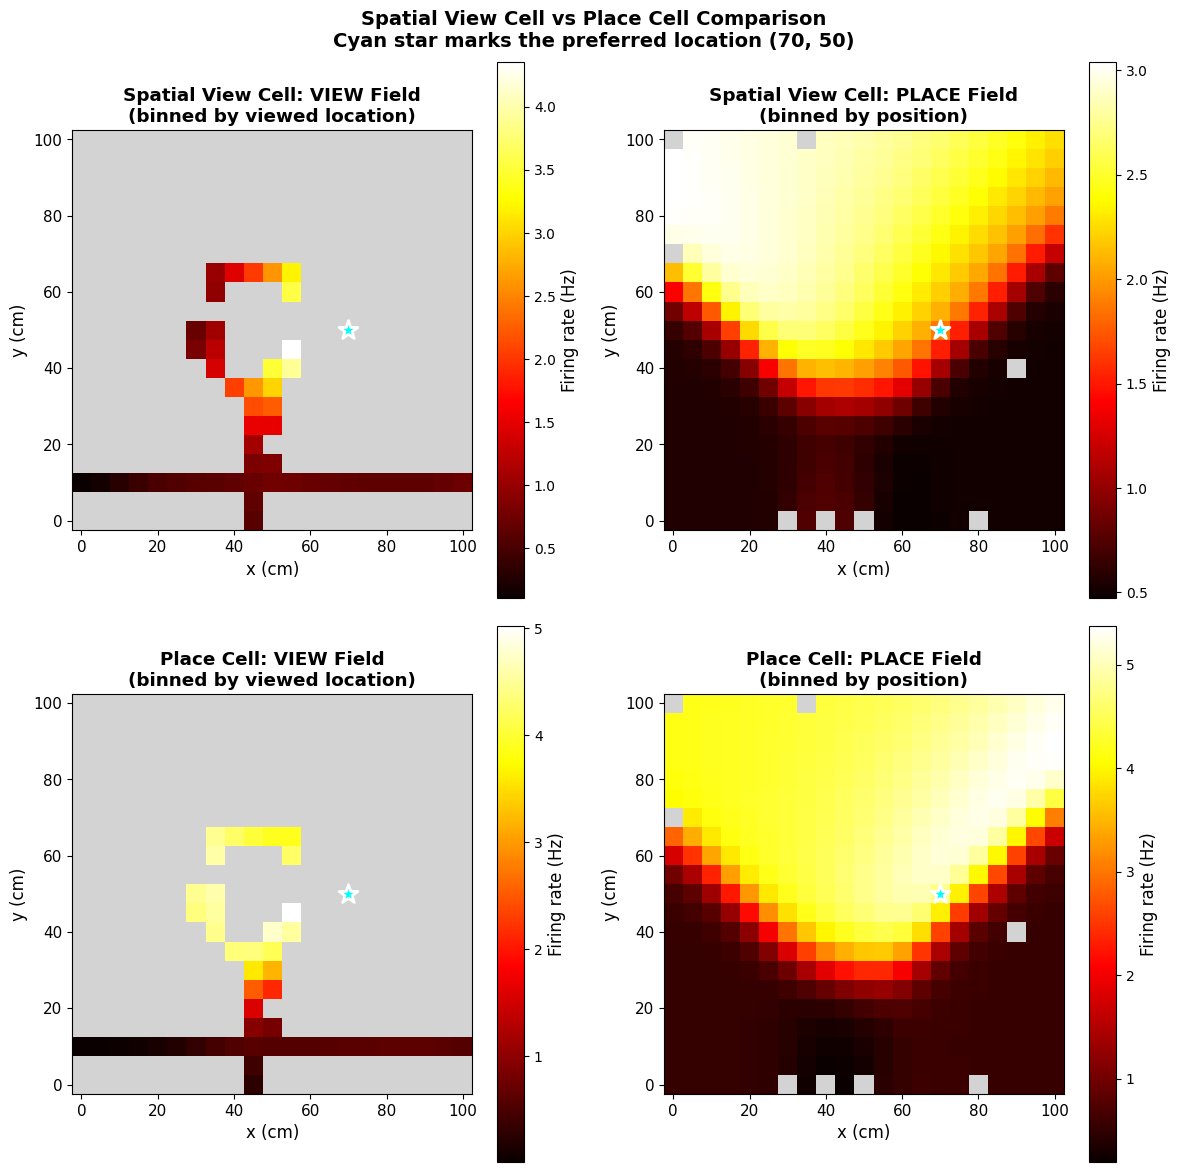


Observations:
- Spatial view cell: VIEW field shows clear peak at preferred location
- Spatial view cell: PLACE field is diffuse (fires from many positions)
- Place cell: PLACE field shows clear peak at preferred location
- Place cell: VIEW field is diffuse (views many locations from preferred position)


In [9]:
# Visualize fields
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Row 1: Spatial view cell
ax = axes[0, 0]
env.plot_field(svc_view_field, ax=ax, cmap="hot", colorbar_label="Firing rate (Hz)")
ax.scatter(
    [preferred_view[0]],
    [preferred_view[1]],
    c="cyan",
    s=200,
    marker="*",
    zorder=5,
    edgecolors="white",
    linewidths=2,
)
ax.set_title(
    "Spatial View Cell: VIEW Field\n(binned by viewed location)", fontweight="bold"
)
ax.set_xlabel("x (cm)")
ax.set_ylabel("y (cm)")

ax = axes[0, 1]
env.plot_field(svc_place_field, ax=ax, cmap="hot", colorbar_label="Firing rate (Hz)")
ax.scatter(
    [preferred_view[0]],
    [preferred_view[1]],
    c="cyan",
    s=200,
    marker="*",
    zorder=5,
    edgecolors="white",
    linewidths=2,
)
ax.set_title("Spatial View Cell: PLACE Field\n(binned by position)", fontweight="bold")
ax.set_xlabel("x (cm)")
ax.set_ylabel("y (cm)")

# Row 2: Place cell
ax = axes[1, 0]
env.plot_field(pc_view_field, ax=ax, cmap="hot", colorbar_label="Firing rate (Hz)")
ax.scatter(
    [70], [50], c="cyan", s=200, marker="*", zorder=5, edgecolors="white", linewidths=2
)
ax.set_title("Place Cell: VIEW Field\n(binned by viewed location)", fontweight="bold")
ax.set_xlabel("x (cm)")
ax.set_ylabel("y (cm)")

ax = axes[1, 1]
env.plot_field(pc_place_field, ax=ax, cmap="hot", colorbar_label="Firing rate (Hz)")
ax.scatter(
    [70], [50], c="cyan", s=200, marker="*", zorder=5, edgecolors="white", linewidths=2
)
ax.set_title("Place Cell: PLACE Field\n(binned by position)", fontweight="bold")
ax.set_xlabel("x (cm)")
ax.set_ylabel("y (cm)")

fig.suptitle(
    "Spatial View Cell vs Place Cell Comparison\n"
    "Cyan star marks the preferred location (70, 50)",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Spatial view cell: VIEW field shows clear peak at preferred location")
print("- Spatial view cell: PLACE field is diffuse (fires from many positions)")
print("- Place cell: PLACE field shows clear peak at preferred location")
print(
    "- Place cell: VIEW field is diffuse (views many locations from preferred position)"
)

## Part 7: Classify Cells Using Metrics

The `spatial_view_cell_metrics` function computes statistics that help distinguish
spatial view cells from place cells.

In [10]:
# Classify cells
svc_metrics = spatial_view_cell_metrics(
    env, svc_spikes, times, positions, headings, view_distance=15.0
)

pc_metrics = spatial_view_cell_metrics(
    env, pc_spikes, times, positions, headings, view_distance=15.0
)

print("=" * 60)
print("SPATIAL VIEW CELL METRICS")
print("=" * 60)
print(svc_metrics.interpretation())

print("\n" + "=" * 60)
print("PLACE CELL METRICS")
print("=" * 60)
print(pc_metrics.interpretation())

SPATIAL VIEW CELL METRICS
*** SPATIAL VIEW CELL ***
View field info: 0.495 bits/spike
Place field info: 0.238 bits/spike
View/Place info ratio: 2.08
View-place correlation: 0.021
View field sparsity: 0.438
View field coherence: nan

PLACE CELL METRICS
Not classified as spatial view cell
View field info: 0.905 bits/spike
Place field info: 0.555 bits/spike
View/Place info ratio: 1.63
View-place correlation: 0.816

Possible reasons:
  - View and place fields too correlated (should be < 0.7 for distinct representations)


In [11]:
# Quick classification summary
print("\n" + "=" * 60)
print("CLASSIFICATION SUMMARY")
print("=" * 60)
print(f"Spatial view cell classified as SVC: {svc_metrics.is_spatial_view_cell}")
print(f"Place cell classified as SVC: {pc_metrics.is_spatial_view_cell}")

print("\nKey metrics comparison:")
print(f"  {'Metric':<30} {'SVC':<15} {'Place Cell':<15}")
print(f"  {'-' * 60}")
print(
    f"  {'View field info (bits/spike)':<30} {svc_metrics.view_field_skaggs_info:.3f}{'':<10} {pc_metrics.view_field_skaggs_info:.3f}"
)
print(
    f"  {'Place field info (bits/spike)':<30} {svc_metrics.place_field_skaggs_info:.3f}{'':<10} {pc_metrics.place_field_skaggs_info:.3f}"
)

# Compute view/place ratio
svc_ratio = (
    svc_metrics.view_field_skaggs_info / svc_metrics.place_field_skaggs_info
    if svc_metrics.place_field_skaggs_info > 0
    else float("inf")
)
pc_ratio = (
    pc_metrics.view_field_skaggs_info / pc_metrics.place_field_skaggs_info
    if pc_metrics.place_field_skaggs_info > 0
    else float("inf")
)
print(f"  {'View/Place info ratio':<30} {svc_ratio:.3f}{'':<10} {pc_ratio:.3f}")


CLASSIFICATION SUMMARY
Spatial view cell classified as SVC: True
Place cell classified as SVC: False

Key metrics comparison:
  Metric                         SVC             Place Cell     
  ------------------------------------------------------------
  View field info (bits/spike)   0.495           0.905
  Place field info (bits/spike)  0.238           0.555
  View/Place info ratio          2.083           1.630


## Part 8: Field of View Analysis

Different species have different fields of view. The `FieldOfView` class provides
presets for common species and allows checking which directions are visible.

In [12]:
print("=" * 60)
print("FIELD OF VIEW ANALYSIS")
print("=" * 60)

fov_rat = FieldOfView.rat()
fov_primate = FieldOfView.primate()

print(f"Rat FOV: {fov_rat.total_angle_degrees:.0f}° total")
print(f"  Left angle: {np.degrees(fov_rat.left_angle):.0f}°")
print(f"  Right angle: {np.degrees(fov_rat.right_angle):.0f}°")

print(f"\nPrimate FOV: {fov_primate.total_angle_degrees:.0f}° total")
print(f"  Left angle: {np.degrees(fov_primate.left_angle):.0f}°")
print(f"  Right angle: {np.degrees(fov_primate.right_angle):.0f}°")

FIELD OF VIEW ANALYSIS
Rat FOV: 320° total
  Left angle: 160°
  Right angle: -160°

Primate FOV: 180° total
  Left angle: 90°
  Right angle: -90°


In [13]:
# Check if specific directions are in FOV
test_bearings = np.array([0, np.pi / 4, np.pi / 2, np.pi, -np.pi / 2])
labels = ["ahead (0°)", "45° left", "left (90°)", "behind (180°)", "right (-90°)"]

print("\nVisibility check:")
print(f"  {'Direction':<20} {'Rat':<10} {'Primate':<10}")
print(f"  {'-' * 40}")
for bearing, label in zip(test_bearings, labels, strict=True):
    rat_visible = fov_rat.contains_angle(bearing)
    primate_visible = fov_primate.contains_angle(bearing)
    print(
        f"  {label:<20} {'yes' if rat_visible else 'no':<10} {'yes' if primate_visible else 'no':<10}"
    )


Visibility check:
  Direction            Rat        Primate   
  ----------------------------------------
  ahead (0°)           yes        yes       
  45° left             yes        yes       
  left (90°)           yes        yes       
  behind (180°)        no         no        
  right (-90°)         yes        yes       


## Summary

In this notebook, you learned:

### Key Concepts
- **Spatial view cells** fire based on *where the animal is looking*, not where it is
- **Place cells** fire based on *where the animal is located*
- **View fields** are indexed by viewed location (use `compute_spatial_view_field`)
- **Place fields** are indexed by animal position (use `compute_place_field`)

### Classification
- Spatial view cells have higher view field information than place field information
- The view/place info ratio (`view_field_skaggs_info / place_field_skaggs_info`) distinguishes cell types
- Values > 1.5 suggest spatial view tuning; values < 1 suggest place tuning

### Field of View
- Different species have different visual fields
- Use `FieldOfView.rat()` or `FieldOfView.primate()` for common presets
- Custom FOV can be created with `FieldOfView(left_limit, right_limit)`

### Next Steps
- Apply to real neural data with tracked eye/head position
- Combine with egocentric reference frame analysis
- Explore boundary vector cells and object vector cells